# PSE Project 1: On the Interpretability of Machine Learning

**TEAM K**

Chouliaras Andreas

Pappas Apostolos

Stylianos Gkountouvas

In [2]:
import collections
import re


import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from graphviz import Source
from IPython.display import SVG

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, get_dataset, info_plots

import shap

import skater
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

sns.set()
shap.initjs()

# Census Income Dataset

Features:
* **age**: continuous.
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* **education-num**: continuous.
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-* inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* **sex**: Female, Male.
* **capital-gain**: continuous.
* **capital-loss**: continuous.
* **hours-per-week**: continuous.
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Target: Whether the individual makes **more than 50K $ per month or not**

In [3]:
data_disp, labels_disp = shap.datasets.adult(display=True)
shap.datasets.adult(display=True)[0].head()

Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
4  28.0            Private           13.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   Capital Loss  Hours per week         Country  
0           0.0            40.0   United-States  
1           0.0            13.0   United-States  
2           0.0            40.0   United-States  
3           0.0            40.0   United-States  
4           0.0            40.0            Cuba

In [4]:
data, labels = shap.datasets.adult(display=False)

data_with_labels = data.copy()
data_with_labels["Target"]=labels

feature_names = list(data.columns)

shap.datasets.adult(display=False)[0].head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             0   
1  50.0          6           13.0               2           4             4   
2  38.0          4            9.0               0           6             0   
3  53.0          4            7.0               2           6             4   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

In [5]:
data.describe().T

count         mean          std   min   25%   50%   75%  \
Age             32561.0    38.581646    13.640432  17.0  28.0  37.0  48.0   
Workclass       32561.0     3.868892     1.455960   0.0   4.0   4.0   4.0   
Education-Num   32561.0    10.080679     2.572720   1.0   9.0  10.0  12.0   
Marital Status  32561.0     2.611836     1.506222   0.0   2.0   2.0   4.0   
Occupation      32561.0     6.572740     4.228857   0.0   3.0   7.0  10.0   
Relationship    32561.0     2.494518     1.758232   0.0   0.0   3.0   4.0   
Race            32561.0     3.665858     0.848806   0.0   4.0   4.0   4.0   
Sex             32561.0     0.669205     0.470506   0.0   0.0   1.0   1.0   
Capital Gain    32561.0  1077.648804  7385.291992   0.0   0.0   0.0   0.0   
Capital Loss    32561.0    87.303833   402.960205   0.0   0.0   0.0   0.0   
Hours per week  32561.0    40.437454    12.347429   1.0  40.0  40.0  45.0   
Country         32561.0    36.718866     7.823782   0.0  39.0  39.0  39.0   

                    max  
Age                90.0  
Workclass           8.0  
Education-Num      16.0  
Marital Status      6.0  
Occupation         14.0  
Relationship        5.0  
Race                4.0  
Sex                 1.0  
Capital Gain    99999.0  
Capital Loss     4356.0  
Hours per week     99.0  
Country            41.0

# Univariate Analysis

<BarContainer object of 2 artists>

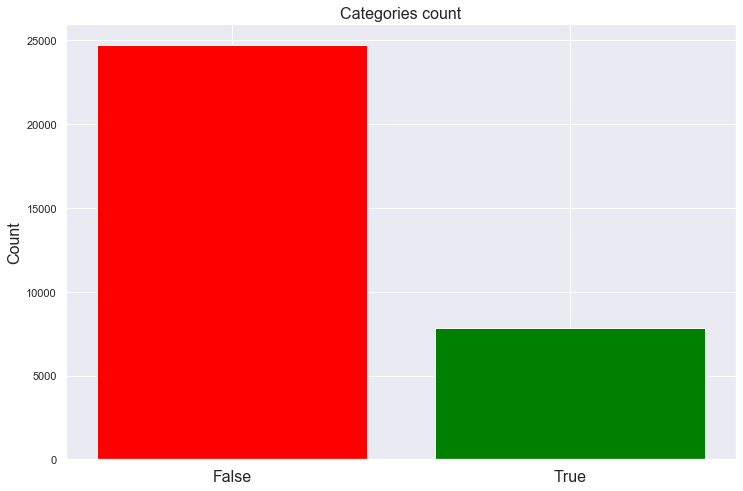

In [5]:
labels_count=collections.Counter(labels)

fig, ax = plt.subplots(figsize=(12,8))


ax.set_xticks(np.arange(len(labels_count.keys())))
ax.set_xticklabels(labels_count.keys(),fontsize=16)
ax.set_ylabel("Count",fontsize=16)
ax.set_title('Categories count',fontsize=16)
ax.bar(labels_count.keys(),labels_count.values(),color=['red', 'green'])

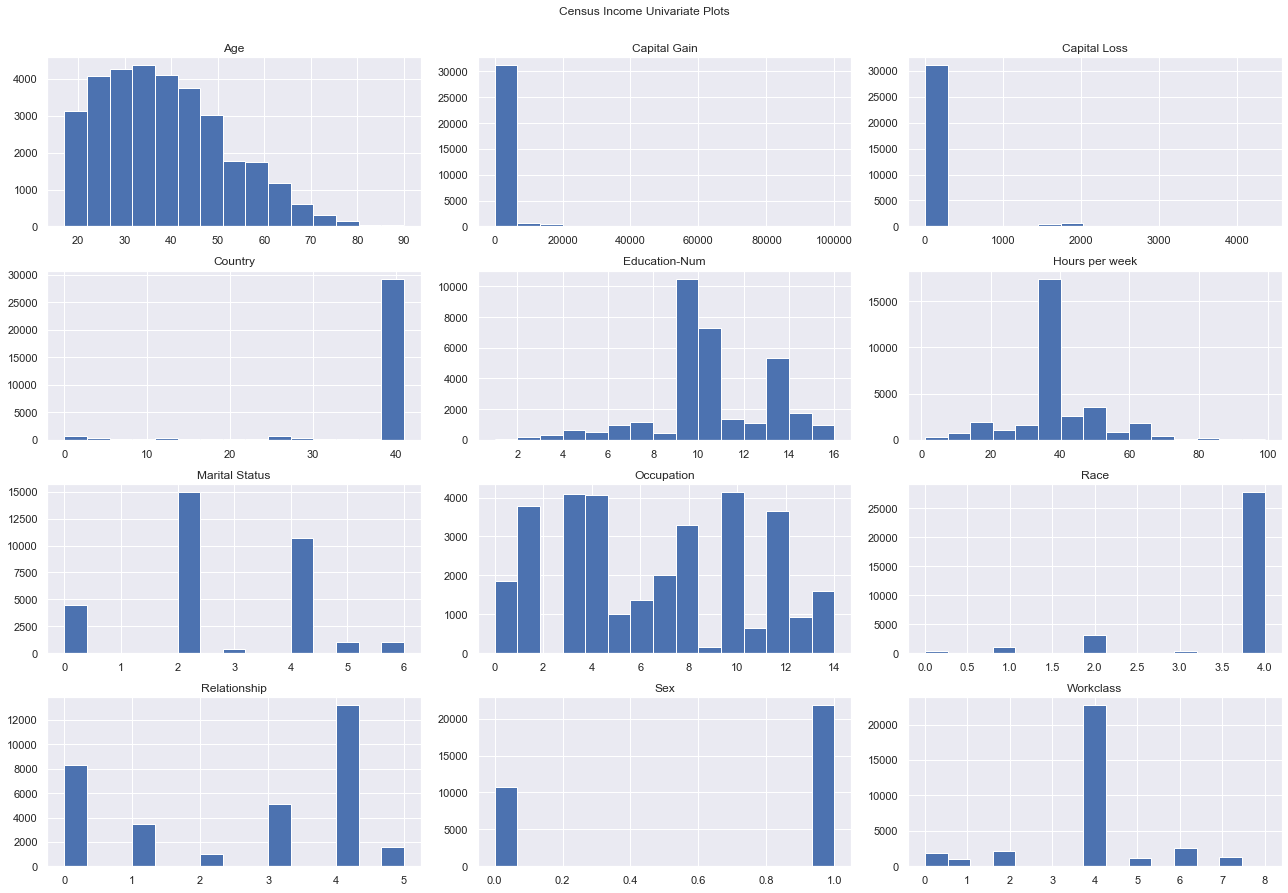

In [6]:
data.hist(bins=15,figsize=(18,12))    
plt.suptitle('Census Income Univariate Plots',y=1.03)  
plt.tight_layout()   

# Multivariate Analysis
Correlation matrix

(13.0, 0.0)

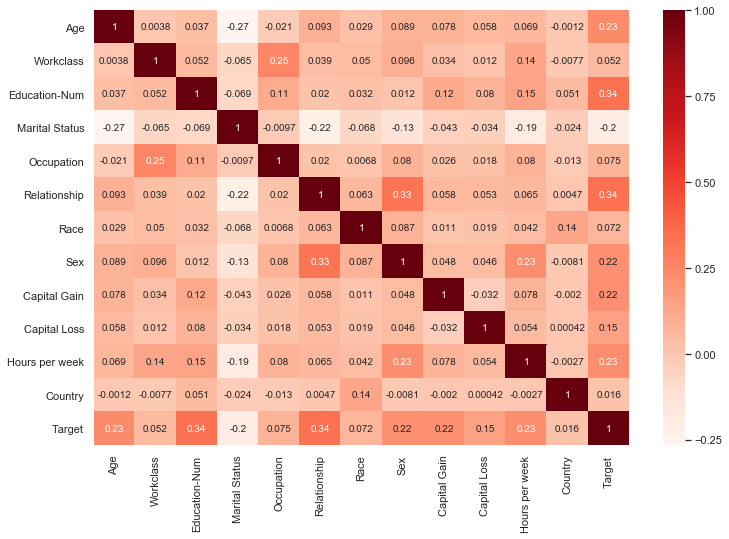

In [7]:
fig, ax = plt.subplots(figsize=(12,8))

sns.heatmap(data_with_labels.corr(),annot=True, ax=ax, cmap="Reds")
#
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#

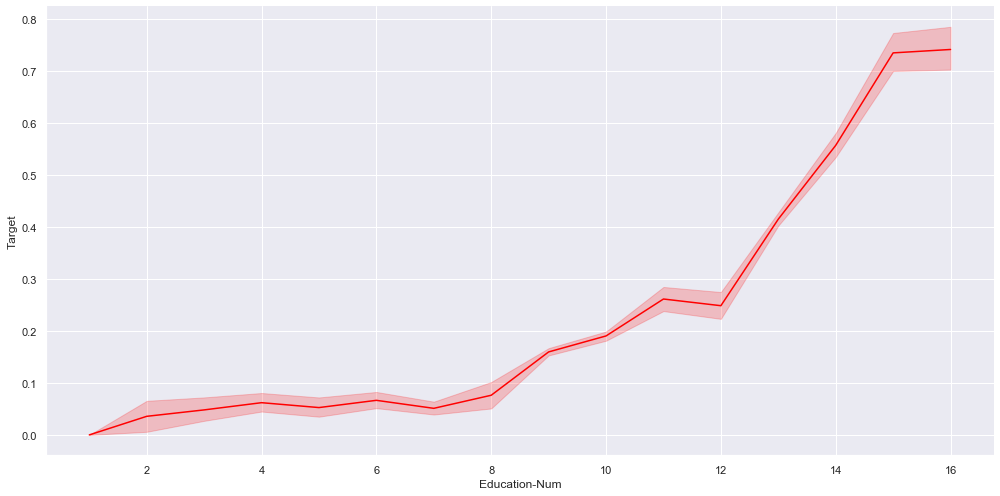

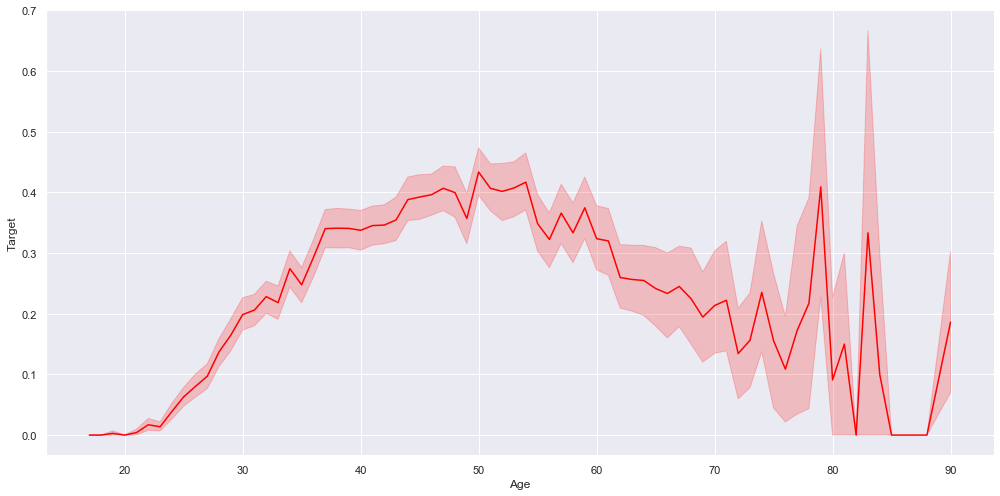

In [8]:
sns.relplot(data=data_with_labels, x='Education-Num', y='Target',kind='line',height=7, aspect=2, color='red')
sns.relplot(data=data_with_labels, x='Age', y='Target',kind='line',height=7, aspect=2, color='red')

# Building Train and Test Datasets

In [7]:
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((22792, 12), (9769, 12))

In [8]:
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

# Making predictions on the test data

In [10]:
predictions = clf.predict(X_test)
print("Score is {0}".format(clf.score(X_test,y_test)))

Score is 0.8129798341693111


# Visualizing the tree

Its not always possible or the logical thing to do

In [12]:
dotfile = open("dt.dot", 'w')
tree.export_graphviz(clf, out_file=dotfile, feature_names=feature_names)
dotfile.close()

# convert .dot to .svg with graphviz from command line

svgfile =  open("tree.svg", 'r')
for line in svgfile:
    if "width" in line:
        dimensions = re.findall('\d+', line)
svgfile.close()

print("Witdh: {0}px Height: {1}px".format(dimensions[0],dimensions[1]))

Witdh: 104094px Height: 3909px


# Using libraries designed for this task

## Model Interpretation with ELI5

### Feature Importances

In [13]:
eli5.show_weights(clf,feature_names=feature_names,show=['feature_importances'])

### Explaining Model Prediction Decisions
#### Predicting when a person's income <= $50K

In [14]:
index = 0
print('Actual Label:', y_test[index])
print('Predicted Label:', predictions[index])
eli5.show_prediction(clf, X_test.iloc[index],feature_names=list(data.columns),show_feature_values=True)

Actual Label: False
Predicted Label: False


#### Predicting when a person's income > $50K

In [15]:
index = 2
print('Actual Label:', y_test[index])
print('Predicted Label:', predictions[index])
eli5.show_prediction(clf, X_test.iloc[index],feature_names=list(data.columns),show_feature_values=True)

Actual Label: True
Predicted Label: True


### Features Permutation Importances

eli5 provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “permutation importance” or “Mean Decrease Accuracy (MDA)”.

The idea is the following: feature importance can be measured by looking at how much the score (accuracy, F1, R^2, etc. - any score we’re interested in) decreases when a feature is not available.

To do that one can remove feature from the dataset, re-train the estimator and check the score. But it requires re-training an estimator for each feature, which can be computationally intensive. Also, it shows what may be important within a dataset, not what is important within a concrete trained model.

To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.

In [16]:
perm = PermutationImportance(clf).fit(X_test, y_test)
eli5.show_weights(perm)

In [17]:
eli5.show_weights(perm,feature_names=feature_names,show=['feature_importances'])

#### Interpreting Permutation Importances

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

Negative values for permutation importances means that the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate.

## Partial Dependence Plots

The partial dependence plot (PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model.

**A PD plot can show whether the relationship between the target and a feature is linear, monotonous or more complex.**


In [18]:
pdp_edu = pdp.pdp_isolate(model=clf, dataset=data, model_features=feature_names, feature='Education-Num')

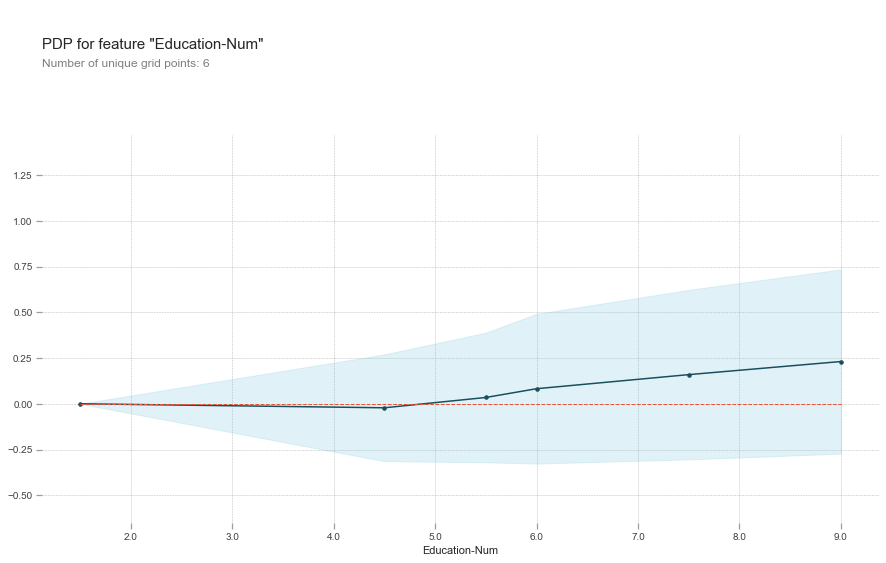

In [19]:
fig, axes = pdp.pdp_plot(pdp_edu, 'Education-Num')
axes['pdp_ax'].set_xticklabels(np.sort(data["Education-Num"].unique()));

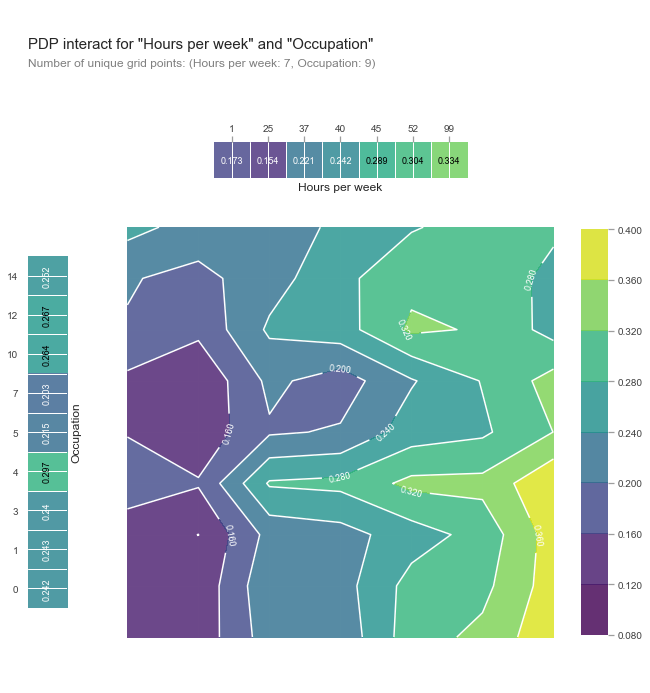

In [20]:
f=['Hours per week', 'Occupation']

inter = pdp.pdp_interact(model=clf, dataset=data, model_features=feature_names, features=f)

fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter, feature_names=f, plot_type='contour', x_quantile=True, plot_pdp=True)

## Feature Importances with SHAP

In [21]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

### Predicting when a person's income > $50K

In [22]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_disp.iloc[0,:])

### Predicting when a person's income <= $50K


In [23]:
shap.force_plot(explainer.expected_value[0], shap_values[0][2,:], X_test_disp.iloc[2,:])

### Visualizing and explaining multiple predictions
One of the key advantages of SHAP is it can build beautiful interactive plots which can visualize and explain multiple predictions at once. Here we visualize model prediction decisions for the first 1000 test data samples.

In [24]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:1000,:], X_test_disp.iloc[:1000,:])

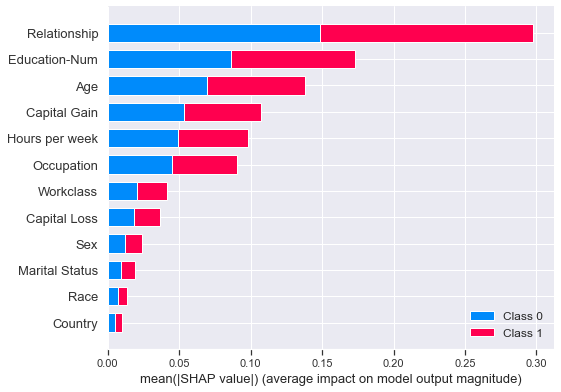

In [25]:
shap.summary_plot(shap_values, X_test)

There are many more functions that cant be covered here

## Model Interpretation with Skater

Skater is a unified framework to enable Model Interpretation for all forms of model to help one build an Interpretable machine learning system often needed for real world use-cases.

It is an open source python library designed to demystify the learned structures of a black box model both globally(inference on the basis of a complete data set) and locally(inference about an individual prediction).

### Global Interpretations with Skater

#### Estimate Variable Importance

[12/12] features ████████████████████ Time elapsed: 0 seconds

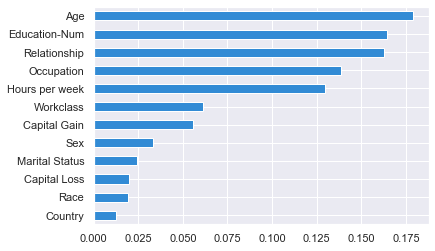

In [11]:
interpreter = Interpretation(X_test, feature_names=feature_names)
model = InMemoryModel(clf.predict_proba, examples=X_train,target_names=['$50K or less', 'More than $50K'])
plots = interpreter.feature_importance.plot_feature_importance(model, ascending=False)

#### Two-way PD Plot showing interactions between features 'Age' and 'Education-Num'

[480/480] grid cells ████████████████████ Time elapsed: 7 seconds

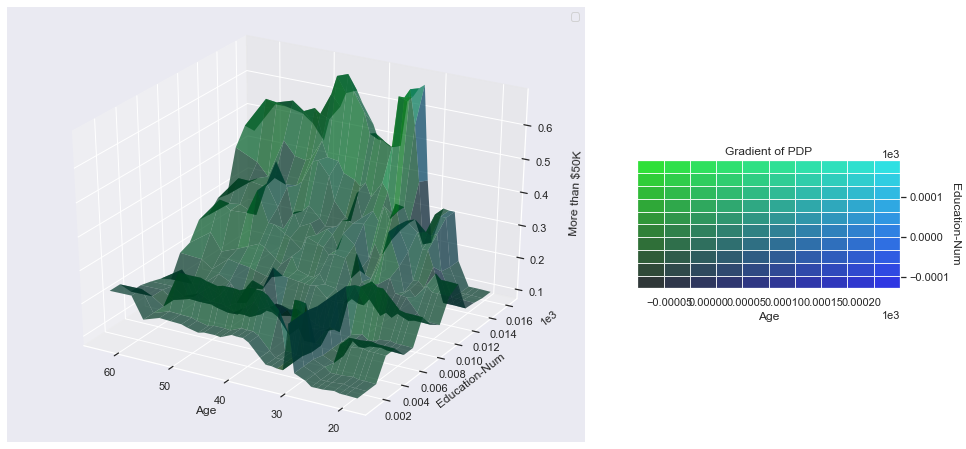

In [12]:
interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')],model,n_samples=23000,figsize=(16, 8));

### Local Interpretations with Skater
**Local Interpretable Model-Agnostic Explanations(LIME)**

LIME is a novel algorithm designed by Riberio Marco, Singh Sameer, Guestrin Carlos to access the behavior of the any base estimator(model) using interpretable surrogate models (e.g. linear classifier/regressor). Such form of comprehensive evaluation helps in generating explanations which are locally faithful but may not align with the global behavior. Basically, LIME explanations are based on local surrogate models. These, surrogate models are interpretable models (like a linear model or decision tree) that are learned on the predictions of the original black box model. But instead of trying to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Think that your model is a black box model with some magic happening inside, where you can input data points and get the models predicted outcomes. You can probe this magic black box as often as you want with inputs and get output predictions.

In [13]:
exp = LimeTabularExplainer(X_test.values, feature_names=feature_names,discretize_continuous=True,class_names=['$50K or less', 'More than $50K'])

#### Predicting when a person's income <= $50K

In [14]:
index = 0
print('Actual Label:', y_test[index])
print('Predicted Label:', predictions[index])
exp.explain_instance(X_test.iloc[index].values, clf.predict_proba).show_in_notebook()

Actual Label: False
Predicted Label: False


#### Predicting when a person's income > $50K

In [15]:
index = 2
print('Actual Label:', y_test[index])
print('Predicted Label:', predictions[index])
exp.explain_instance(X_test.iloc[index].values, clf.predict_proba).show_in_notebook()

Actual Label: True
Predicted Label: True


### More interpretable models with Tree Surrogates using Skater

Here, we present the idea of using TreeSurrogates as means for explaining a model's learned decision policies which is inspired by the work of Mark W. Craven described as the TREPAN algorithm.

Relevant papers
 - [_Mark W. Craven(1996) EXTRACTING COMPREHENSIBLE MODELS FROM TRAINED NEURAL NETWORKS_](http://ftp.cs.wisc.edu/machine-learning/shavlik-group/craven.thesis.pdf)
 - [_Mark W. Craven and Jude W. Shavlik(NIPS, 96). Extracting Thee-Structured Representations of Thained Networks_](https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf)
 
There are various ways to interpret machine learning models with features, dependence plots and even LIME. This method tries to build an approximation or a surrogate model which is more interpretable from a really complex black box model.

In [35]:
surrogate_explainer = interpreter.tree_surrogate(oracle=model, seed=420)
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2019-10-22 03:56:01,893 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2019-10-22 03:56:01,894 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2019-10-22 03:56:02,770 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (22792, 2)
2019-10-22 03:56:02,802 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.83; oracle score 0.981
2019-10-22 03:56:02,804 - skater.core.global_interpretation.tree_surrogate - WARNING - impurity score: 0.151 of the surrogate model is higher than the impurity threshold: 0.01. The higher the impurity score, lower is the fidelity/faithfulness of the surrogate model


0.151

In [36]:
pd.DataFrame([('X'+str(idx), feature) for (idx, feature) in enumerate(data.columns)]).T

0          1              2               3           4             5  \
0   X0         X1             X2              X3          X4            X5   
1  Age  Workclass  Education-Num  Marital Status  Occupation  Relationship   

      6    7             8             9              10       11  
0    X6   X7            X8            X9             X10      X11  
1  Race  Sex  Capital Gain  Capital Loss  Hours per week  Country

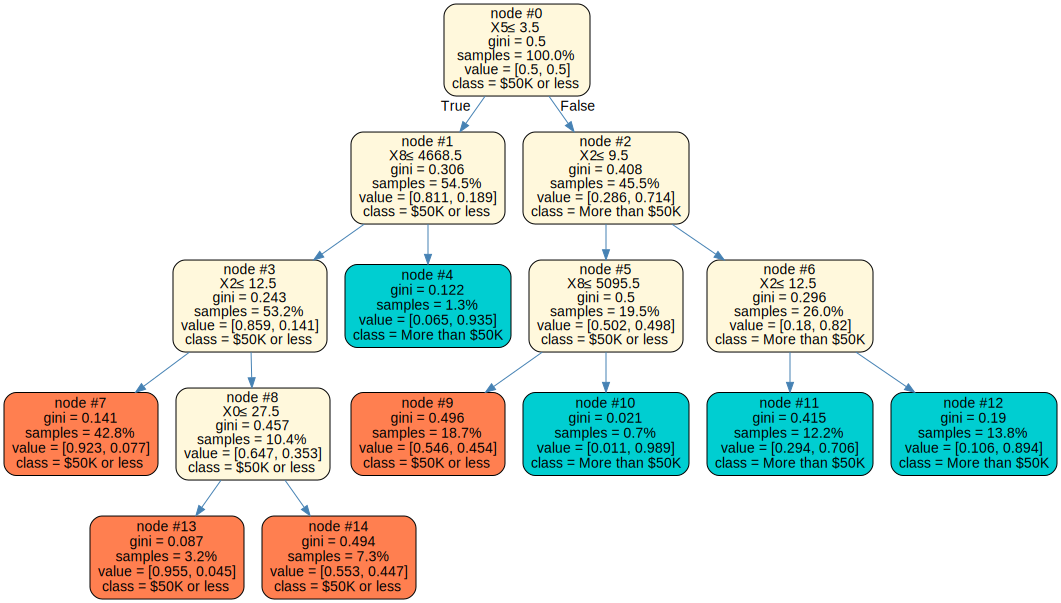

In [37]:
graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'],file_name='test_tree_pre.png').to_string())
svg_data = graph.pipe(format='svg')
with open('dtree_structure.svg','wb') as f:
    f.write(svg_data)
SVG(svg_data)

## ELI5 TextExplainer: debugging black-box text classifiers

In [46]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline

from eli5.lime import TextExplainer

In [42]:
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train',categories=categories,shuffle=True,random_state=420,remove=('headers', 'footers'))
twenty_test = fetch_20newsgroups(subset='test',categories=categories,shuffle=True,random_state=420,remove=('headers', 'footers'))

In [43]:
vec = TfidfVectorizer(min_df=3, stop_words='english',
                      ngram_range=(1, 2))
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
lsa = make_pipeline(vec, svd)

clf = SVC(C=150, gamma=2e-2, probability=True)
pipe = make_pipeline(lsa, clf)
pipe.fit(twenty_train.data, twenty_train.target)
pipe.score(twenty_test.data, twenty_test.target)

0.8854860186418109

In [44]:
def print_prediction(doc):
    y_pred = pipe.predict_proba([doc])[0]
    for target, prob in zip(twenty_train.target_names, y_pred):
        print("{:.3f} {}".format(prob, target))

doc = twenty_test.data[0]
print_prediction(doc)

0.000 alt.atheism
0.000 comp.graphics
1.000 sci.med
0.000 soc.religion.christian


In [47]:
te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction(target_names=twenty_train.target_names)